In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, cos, sin, sqrt, pi
from scipy.io import loadmat
import random

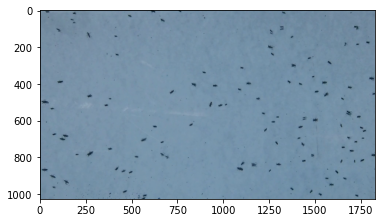

In [5]:
cap = cv2.VideoCapture('video_clips/preprocessed_133_10sec_710.avi')
data = loadmat('sequence_7/frame_1.mat')

featarray = data['featarray']

width = int(cap.get(3))
height = int(cap.get(4))

_, frm = cap.read()

plt.imshow(frm)

In [6]:
old = cv2.cvtColor(frm, cv2.COLOR_BGR2GRAY)
first = old.copy()

thresh = cv2.threshold(first, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
connComp = cv2.connectedComponentsWithStats(thresh, 1, cv2.CV_32S)
(num, labels, stats, centroids) = connComp

prev_pos = [(-1, -1)] * 500
angles = [-1] * 500
pts = []

for i in range (1, num):
    pts.append((int(centroids[i][0]),int(centroids[i][1])))

old_pts = np.array(pts, dtype = np.float32)

index = 120

fx = stats[index, cv2.CC_STAT_LEFT]
fy = stats[index, cv2.CC_STAT_TOP]
fw = stats[index, cv2.CC_STAT_WIDTH]
fh = stats[index, cv2.CC_STAT_HEIGHT]

rands = []

t_d = 3

In [7]:
# https://docs.opencv.org/3.4/d1/dee/tutorial_introduction_to_pca.html

def drawAxis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians

    hypotenuse = 3

    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)

    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    cv2.line(img, (int(p[0]), int(p[1])), (int(p[0] + scale * hypotenuse * cos(angle)), 
        int(p[1] + scale * hypotenuse * sin(angle))), colour, 1, cv2.LINE_AA)

def getOrientation(pts, img, clr, aa):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    
    q0 = cntr[0] + 5 * 5 * cos(aa)
    q1 = cntr[1] + 5 * 5 * sin(aa)
    #cv2.line(img, cntr, (int(q0), int(q1)), (255, 0, 0), 1, cv2.LINE_AA)
    
    drawAxis(img, cntr, p1, clr, 5)
    
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    
    return angle

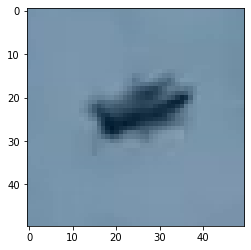

In [8]:
cim = frm
ind = 0
for i in range(0, len(featarray)):
    if int(featarray[i][9]) == 89:
        xc = int(featarray[i][0]*width/100)
        yc = int(featarray[i][1]*height/56.25)
        cim = frm[yc-20:yc+30, xc-20:xc+30]
        ind = i
plt.imshow(cim)

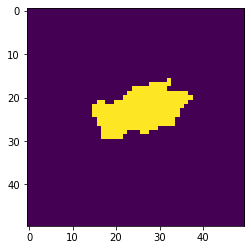

In [9]:
curr = cv2.cvtColor(cim, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(curr, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

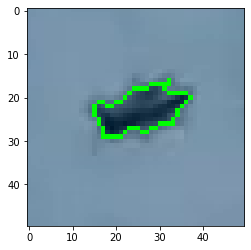

In [10]:
connComp = cv2.connectedComponentsWithStats(thresh, 1, cv2.CV_32S)
(num, labels, stats, centroids) = connComp
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hulls = []
boxes = []
box_es = []

cont = cim.copy()
cv2.drawContours(cont,contours,0,(0, 255, 0),1)
plt.imshow(cont)

In [11]:
for i in range(0, len(contours)):
    c_length = cv2.arcLength(contours[i], True)
    if c_length > 10:
        hull = cv2.convexHull(contours[i])
        hulls.append(hull)
        rect = cv2.minAreaRect(contours[i])
        box_ = cv2.boxPoints(rect)
        box_ = np.int0(box_)
        box_es.append(box_)
        x,y,w,h = cv2.boundingRect(contours[i])
        box = [[x-t_d, y-t_d], [x+w+t_d, y-t_d], [x+w+t_d, y+h+t_d], [x-t_d, y+h+t_d]]
        box = np.int0(box)
        boxes.append(box)

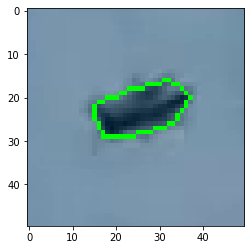

In [12]:
hullt = cim.copy()
cv2.drawContours(hullt,hulls,0,(0, 255, 0),1)
plt.imshow(hullt)

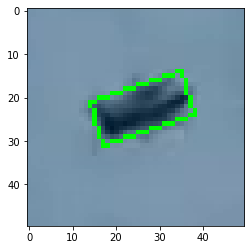

In [13]:
rectt = cim.copy()
cv2.drawContours(rectt,box_es,0,(0, 255, 0),1)
plt.imshow(rectt)

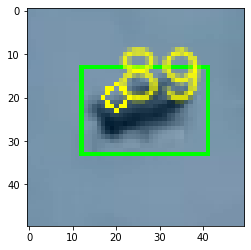

In [14]:
rectt_2 = cim.copy()
cv2.drawContours(rectt_2,boxes,0,(0, 255, 0),1)
cv2.circle(rectt_2,(20, 20),3,(255, 255, 0),1)
cv2.putText(rectt_2, "89", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv2.LINE_AA)
plt.imshow(rectt_2)

In [15]:
ang = cim.copy()
if cv2.pointPolygonTest(boxes[0], (20, 20), True) >= 0:
    # match!
    actual_angle = -featarray[i][4]
    getOrientation(hulls[0], ang, (0, 255, 0), actual_angle)

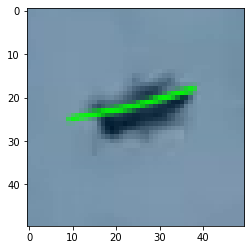

In [16]:
plt.imshow(ang)

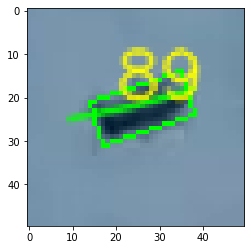

In [17]:
fin = cim.copy()
cv2.drawContours(fin,box_es,0,(0, 255, 0),1)
actual_angle = -featarray[i][4]
getOrientation(hulls[0], fin, (0, 255, 0), actual_angle)
cv2.putText(fin, "89", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv2.LINE_AA)
plt.imshow(fin)